In [1]:
import argparse
import torch
import torch.nn as nn
import torchvision
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
batch_size = 64
num_workers = 0

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.49], [0.248]),
])

val_dataset = torchvision.datasets.DatasetFolder(
    f"/kaggle/input/rsna-pneumonia-detection-olha-babicheva/processed/val/",
    loader=load_file, 
    extensions="npy", 
    transform=val_transforms
)

val_loader = DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

In [4]:
VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

class VGGNet(nn.Module):
    def __init__(self, in_channels: int = 1, num_classes: int = 2):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, 
                                     out_channels=out_channels,
                                     kernel_size=(3,3), 
                                     stride=(1,1), 
                                     padding=(1,1)),
                            nn.BatchNorm2d(x),
                            nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)

In [31]:
model = VGGNet()
model.load_state_dict(torch.load("/kaggle/input/rsna-pneumonia-detection-olha-babicheva/best_model.pth"))
model.eval()
model.to(device)

predictions = []
labels = []


for batch, (X_val, y_val) in enumerate(val_loader):
    with torch.no_grad():
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        pred = model(X_val)
        _, prediction = pred.max(1)
        predictions.append(prediction)
        labels.append(y_val)

In [32]:
predictions = torch.cat([pred for pred in predictions], dim=0)
labels = torch.cat([label for label in labels], dim=0)

In [39]:
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)(predictions, labels)
precision = torchmetrics.Precision(task='multiclass', num_classes=2).to(device)(predictions, labels)
recall = torchmetrics.Recall(task='multiclass', num_classes=2).to(device)(predictions, labels)
cmatrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=2).to(device)(predictions, labels)
cmatrix_threshed = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=2, threshold=0.25).to(device)(predictions, labels)

print(f"Val Accuracy: {accuracy}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cmatrix}")
print(f"Confusion Matrix 2:\n {cmatrix_threshed}")

Val Accuracy: 0.8261195421218872
Val Precision: 0.8261195421218872
Val Recall: 0.8261195421218872
Confusion Matrix:
 tensor([[3885,  468],
        [ 460,  524]], device='cuda:0')
Confusion Matrix 2:
 tensor([[3885,  468],
        [ 460,  524]], device='cuda:0')


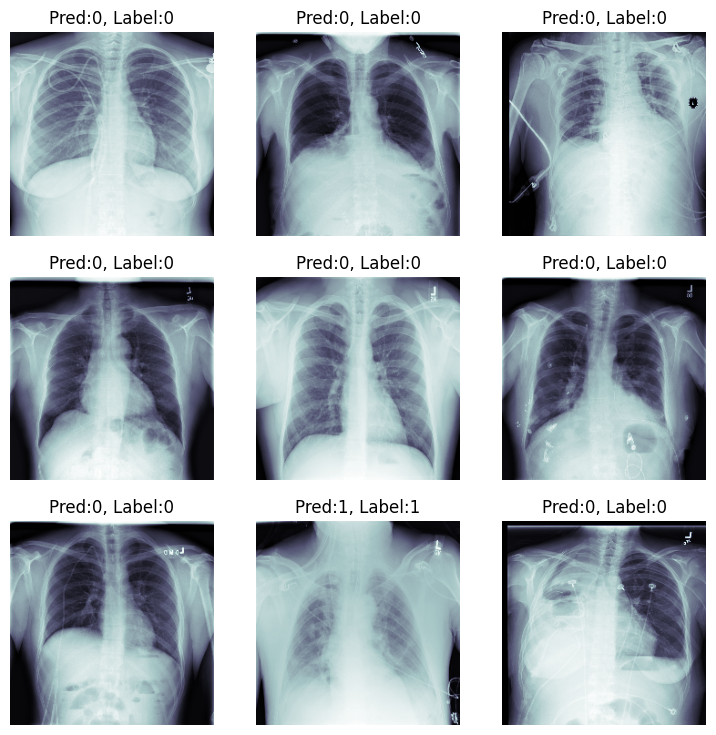

In [40]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(predictions))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(predictions[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

plt.show()